In [1]:
root_dir = "./TLP"

         accuracy   test_loss
count  512.000000  512.000000
mean     0.628027    2.315862
std      0.010924    0.123975
min      0.587750    1.997237
25%      0.620719    2.236919
50%      0.628750    2.314064
75%      0.635500    2.389308
max      0.660625    2.862057

Impact of reg_opts.dirbias:
                      mean       std  count
reg_opts.dirbias                           
False             0.629175  0.010965    256
True              0.626879  0.010782    256

Impact of reg_opts.entropy:
                      mean       std  count
reg_opts.entropy                           
False             0.628040  0.010039    256
True              0.628015  0.011763    256

Impact of reg_opts.var:
                  mean       std  count
reg_opts.var                           
False         0.628043  0.010898    256
True          0.628011  0.010971    256

Impact of lambda_dirbias_eff:
                        mean       std  count
lambda_dirbias_eff                           
0.00        

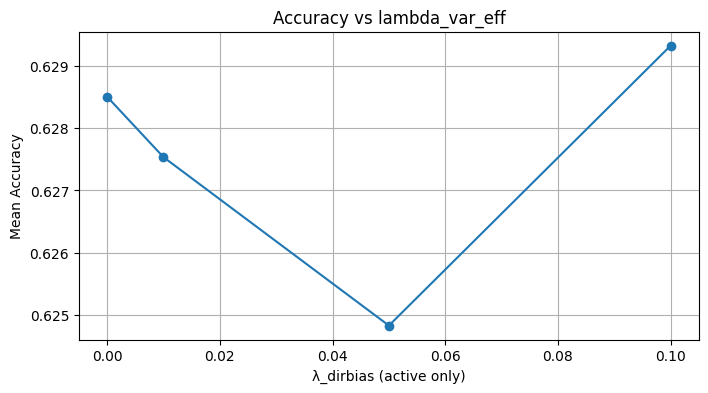

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка логов
log_path = f"{root_dir}/log_TLP.jsonl"
records = []
with open(log_path, "r") as f:
    for line in f:
        records.append(json.loads(line))

# Перевод в DataFrame
df = pd.json_normalize(records)

# Добавим "эффективные" lambda, учитывающие включённость флагов
df["lambda_dirbias_eff"] = df.apply(lambda row: row["reg_opts.lambda_dirbias"] if row["reg_opts.dirbias"] else 0.0, axis=1)
df["lambda_entropy_eff"] = df.apply(lambda row: row["reg_opts.lambda_entropy"] if row["reg_opts.entropy"] else 0.0, axis=1)
df["lambda_var_eff"] = df.apply(lambda row: row["reg_opts.lambda_var"] if row["reg_opts.var"] else 0.0, axis=1)

# Быстрый обзор
print(df[["accuracy", "test_loss"]].describe())

# Влияние каждого рег-флага
for flag in ["reg_opts.dirbias", "reg_opts.entropy", "reg_opts.var"]:
    grouped = df.groupby(flag)["accuracy"].agg(["mean", "std", "count"])
    print(f"\nImpact of {flag}:")
    print(grouped)

# Влияние эффективной lambda (только если регуляризация активна)
for lambd_eff in ["lambda_dirbias_eff", "lambda_entropy_eff", "lambda_var_eff"]:
    grouped = df.groupby(lambd_eff)["accuracy"].agg(["mean", "std", "count"])
    print(f"\nImpact of {lambd_eff}:")
    print(grouped)

# График зависимости точности от lambda_dirbias_eff
plt.figure(figsize=(8, 4))
df.groupby("lambda_var_eff")["accuracy"].mean().plot(marker="o")
plt.title("Accuracy vs lambda_var_eff")
plt.xlabel("λ_dirbias (active only)")
plt.ylabel("Mean Accuracy")
plt.grid(True)
plt.show()

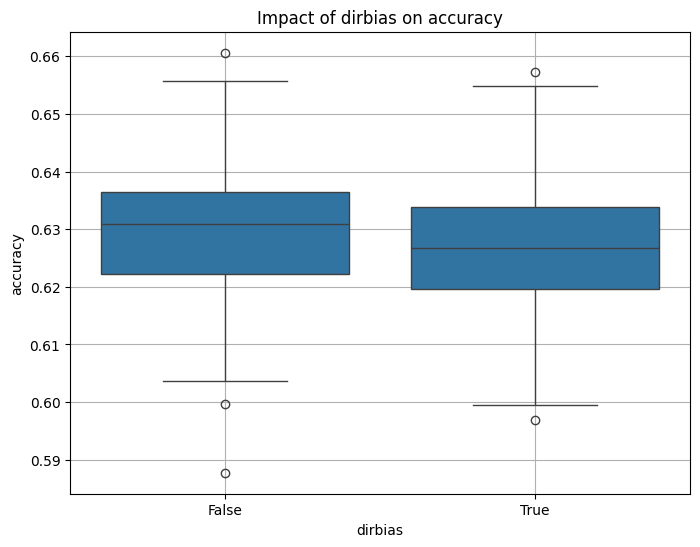

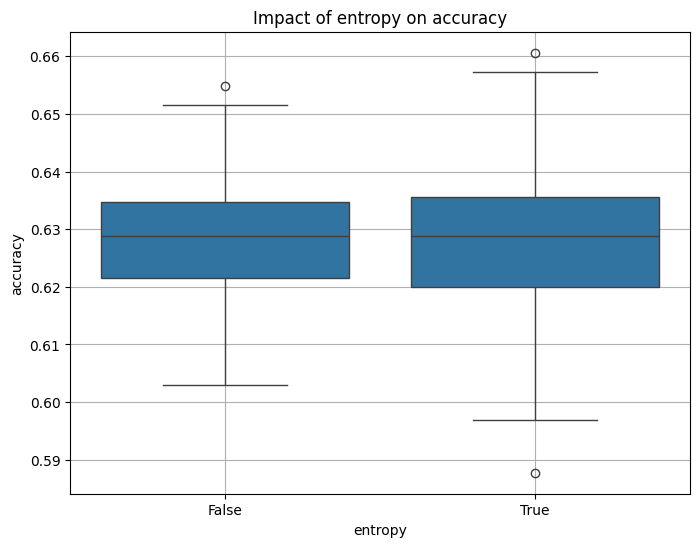

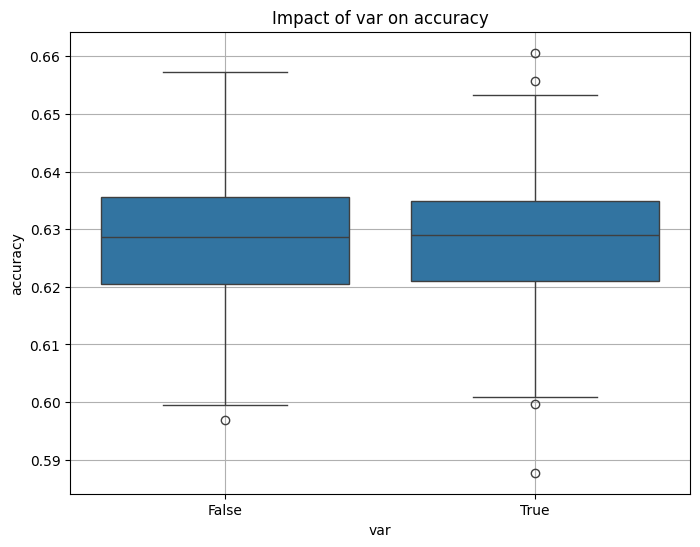

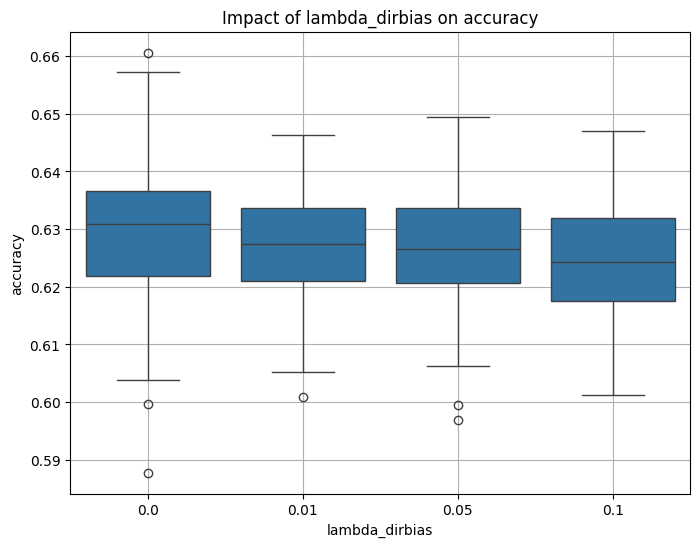

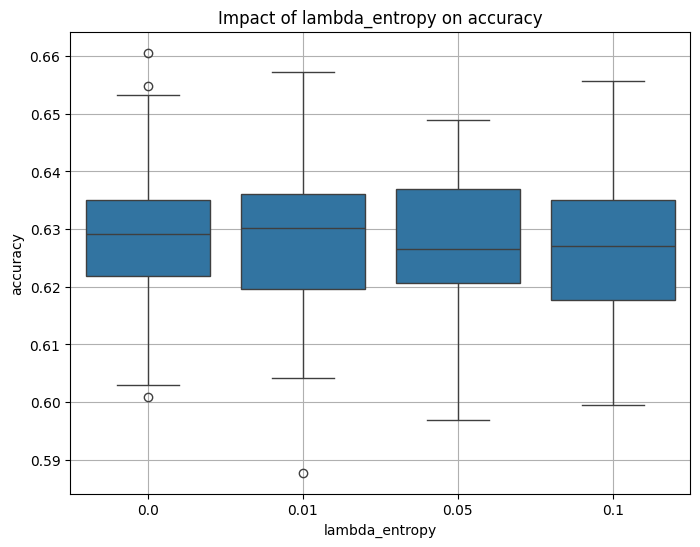

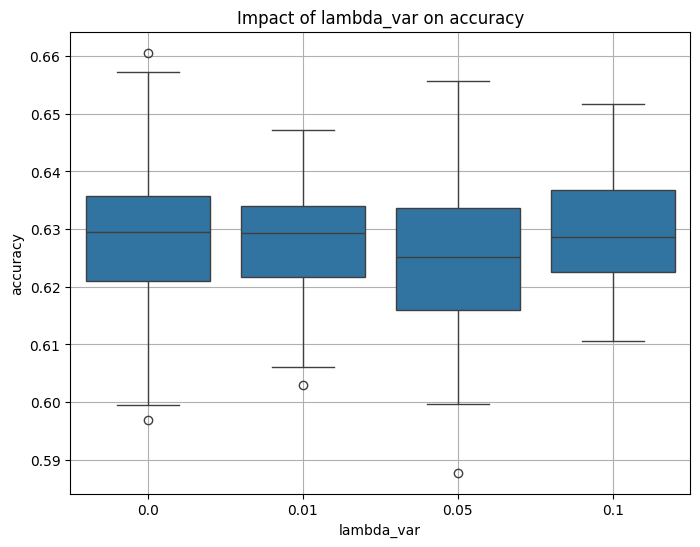

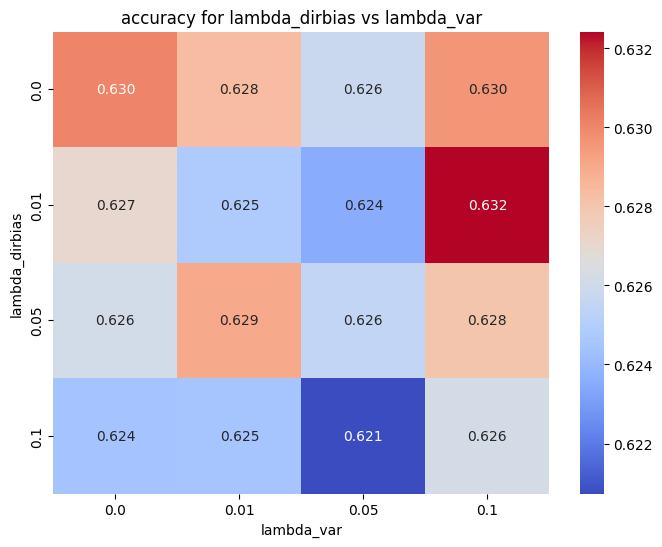

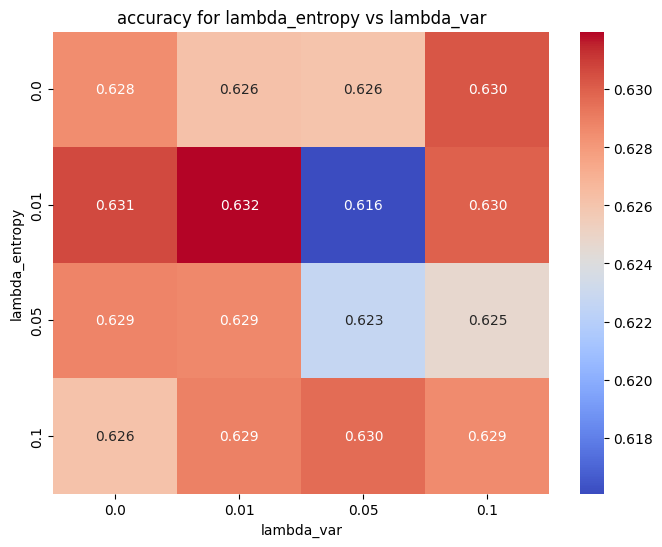

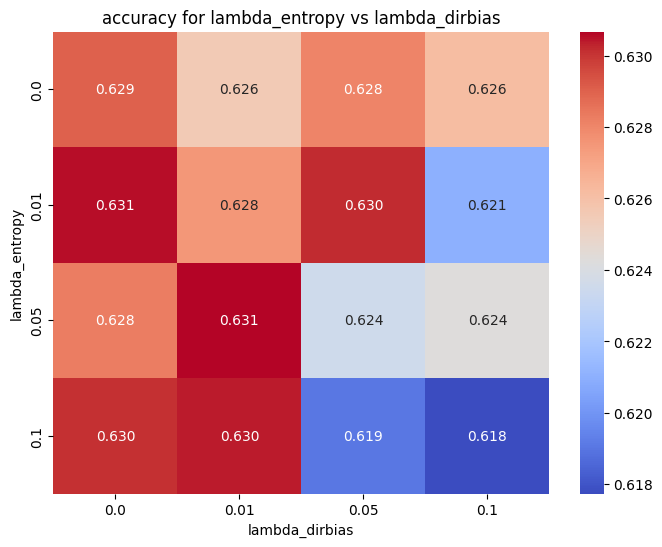

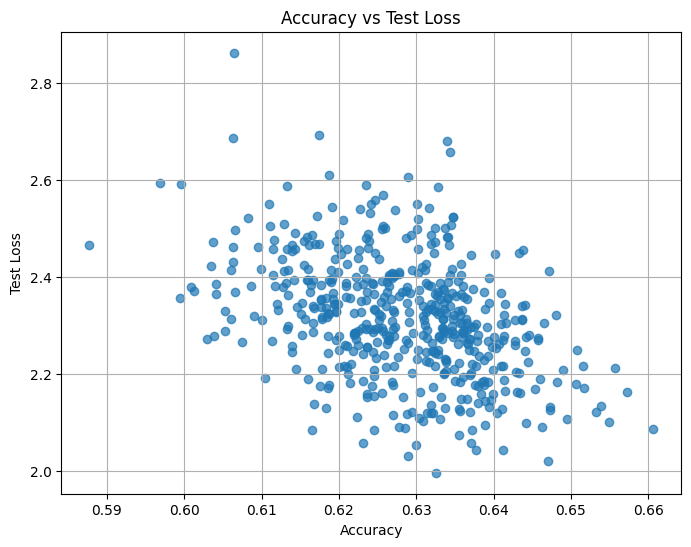

Корреляции между lambda и accuracy: {}


In [3]:
# === Анализ результатов абляционных экспериментов ===

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === 1. Загрузка логов ===


def load_results(log_path):
    records = []
    with open(log_path, "r") as f:
        for line in f:
            data = json.loads(line)
            record = {
                "accuracy": data["accuracy"],
                "test_loss": data["test_loss"],
                "macro_f1": data.get("macro_f1"),
                "weighted_f1": data.get("weighted_f1"),
                "runtime_sec": data["runtime_sec"],
                "uid": data["uid"],
                "method": data["method"],
                "save_dir": data["save_dir"],
            }
            # Распаковываем reg_opts в плоские поля
            reg_opts = data.get("reg_opts", {})
            for key, value in reg_opts.items():
                record[key] = value
            # Добавим эффективные значения λ: 0.0, если флаг выключен
            record["lambda_dirbias"] = record.get("lambda_dirbias", 0.0) if record.get("dirbias", False) else 0.0
            record["lambda_entropy"] = record.get("lambda_entropy", 0.0) if record.get("entropy", False) else 0.0
            record["lambda_var"] = record.get("lambda_var", 0.0) if record.get("var", False) else 0.0
            records.append(record)
    return pd.DataFrame(records)


# === 2. Построение boxplot по каждому признаку ===


def plot_boxplots(df, param, metric="accuracy"):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=param, y=metric, data=df)
    plt.title(f"Impact of {param} on {metric}")
    plt.grid(True)
    plt.show()


# === 3. Построение зависимости лямбда-параметров ===


def plot_lambda_impact(df, lambda_param, metric="accuracy"):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=lambda_param, y=metric, data=df)
    plt.title(f"Impact of {lambda_param} on {metric}")
    plt.grid(True)
    plt.show()


# === 4. Построение heatmap влияния пар параметров ===


def plot_heatmap(df, param1, param2, metric="accuracy"):
    pivot = df.pivot_table(index=param1, columns=param2, values=metric, aggfunc="mean")
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(f"{metric} for {param1} vs {param2}")
    plt.show()


# === 5. Построение scatter: accuracy vs test_loss ===


def plot_scatter_accuracy_vs_loss(df):
    plt.figure(figsize=(8, 6))
    plt.scatter(df["accuracy"], df["test_loss"], alpha=0.7)
    plt.xlabel("Accuracy")
    plt.ylabel("Test Loss")
    plt.title("Accuracy vs Test Loss")
    plt.grid(True)
    plt.show()


# === 6. Корреляционный анализ ===


def compute_correlations(df):
    corrs = {}
    for param in ["lambda_dirbias", "lambda_entropy", "lambda_var"]:
        param_name = f"reg_opts.{param}"
        if param_name in df.columns:
            corr = np.corrcoef(df[param_name], df["accuracy"])[0, 1]
            corrs[param] = corr
    return corrs


# === Пример использования ===

# Загрузим базу
log_path = f"{root_dir}/log_TLP.jsonl"
df = load_results(log_path)

# Базовые графики
plot_boxplots(df, "dirbias")
plot_boxplots(df, "entropy")
plot_boxplots(df, "var")

plot_lambda_impact(df, "lambda_dirbias")
plot_lambda_impact(df, "lambda_entropy")
plot_lambda_impact(df, "lambda_var")

plot_heatmap(df, "lambda_dirbias", "lambda_var")
plot_heatmap(df, "lambda_entropy", "lambda_var")
plot_heatmap(df, "lambda_entropy", "lambda_dirbias")

plot_scatter_accuracy_vs_loss(df)

# Корреляции
corrs = compute_correlations(df)
print("Корреляции между lambda и accuracy:", corrs)

     accuracy  test_loss  lambda_dirbias  lambda_entropy  lambda_var  dirbias  \
256  0.660625   2.087144             0.0            0.00        0.00    False   
70   0.657250   2.162857             0.0            0.01        0.00     True   
270  0.655750   2.212075             0.0            0.10        0.05    False   
198  0.654875   2.101092             0.0            0.00        0.00     True   
366  0.653875   2.133877             0.0            0.10        0.00    False   
0    0.653250   2.121372             0.0            0.00        0.00     True   
311  0.651750   2.171291             0.0            0.01        0.10    False   
197  0.651500   2.215993             0.0            0.00        0.00     True   
415  0.650750   2.250115             0.0            0.00        0.10    False   
79   0.650625   2.180280             0.0            0.10        0.00     True   

     entropy    var                         save_dir  
256     True   True  ./TLP/raw_weights_stl10_3_8_256 

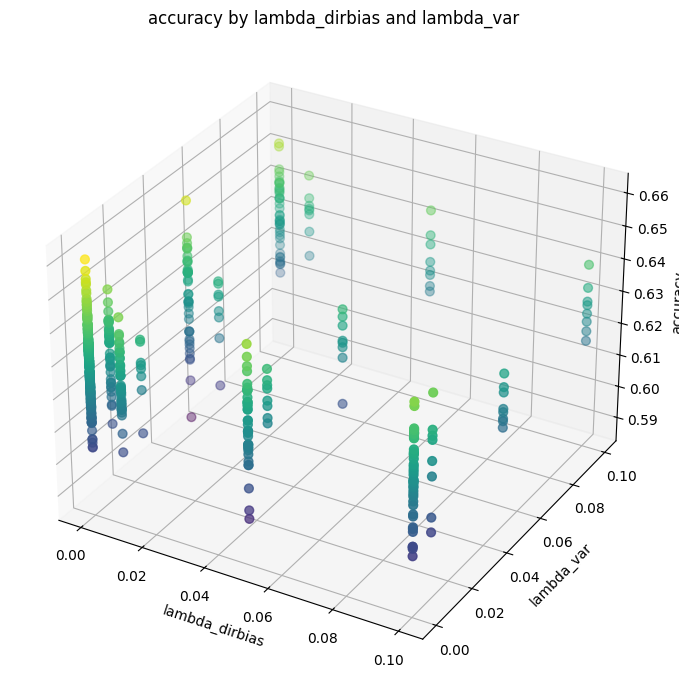

In [4]:
from mpl_toolkits.mplot3d import Axes3D


def print_top_k_configs(df, metric="accuracy", k=10, best=True):
    df_sorted = df.sort_values(by=metric, ascending=not best)
    print(df_sorted[["accuracy", "test_loss", "lambda_dirbias", "lambda_entropy", "lambda_var", "dirbias", "entropy", "var", "save_dir"]].head(k if best else -k))


def plot_3d_lambda_interaction(df, lambda_x, lambda_y, metric="accuracy"):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    xs = df[lambda_x]
    ys = df[lambda_y]
    zs = df[metric]
    ax.scatter(xs, ys, zs, c=zs, cmap="viridis", s=40)
    ax.set_xlabel(lambda_x)
    ax.set_ylabel(lambda_y)
    ax.set_zlabel(metric)
    ax.set_title(f"{metric} by {lambda_x} and {lambda_y}")
    plt.tight_layout()
    plt.show()


print_top_k_configs(df, metric="accuracy", best=True)
plot_3d_lambda_interaction(df, "lambda_dirbias", "lambda_var", "accuracy")

In [5]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

features = ["lambda_dirbias", "lambda_entropy", "lambda_var", "dirbias", "entropy", "var"]
X = df[features].copy()
X[["dirbias", "entropy", "var"]] = X[["dirbias", "entropy", "var"]].astype(int)
y = df["accuracy"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = Ridge(alpha=1.0)
model.fit(X_scaled, y)

for name, coef in zip(features, model.coef_):
    print(f"{name}: {coef:.4f}")

lambda_dirbias: -0.0015
lambda_entropy: -0.0005
lambda_var: -0.0002
dirbias: -0.0003
entropy: 0.0003
var: 0.0001


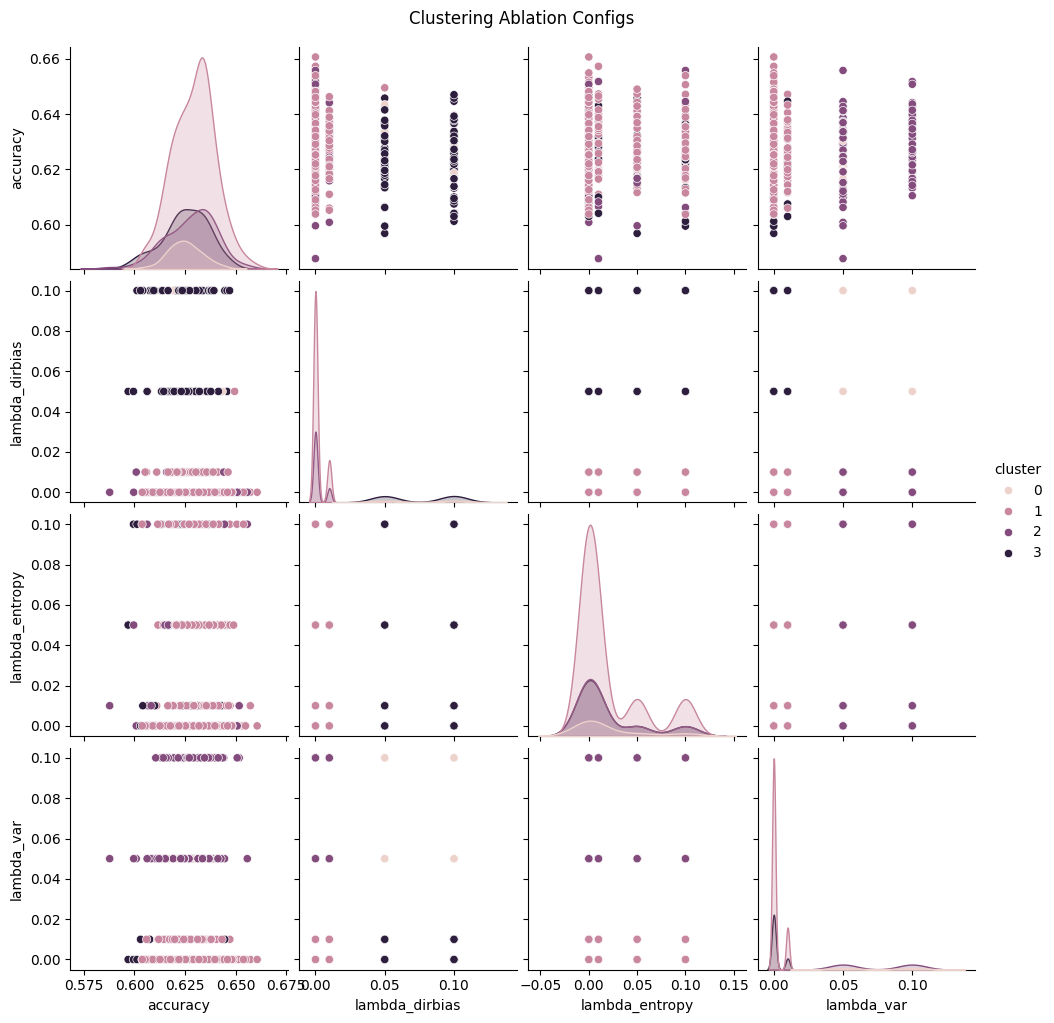

          feature  importance_mean  importance_std
0  lambda_dirbias         0.185343        0.027159
1  lambda_entropy         0.172709        0.026738
2      lambda_var         0.154199        0.024204


In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Предполагаем, что df уже загружен и содержит нужные столбцы
features = ["lambda_dirbias", "lambda_entropy", "lambda_var", "accuracy"]
df_valid = df.dropna(subset=features)

X = df_valid[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df_valid["cluster"] = kmeans.fit_predict(X_scaled)

# Визуализация
sns.pairplot(df_valid, hue="cluster", vars=["accuracy", "lambda_dirbias", "lambda_entropy", "lambda_var"])
plt.suptitle("Clustering Ablation Configs", y=1.02)
plt.show()
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

X = df_valid[["lambda_dirbias", "lambda_entropy", "lambda_var"]]
y = df_valid["accuracy"]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

result = permutation_importance(model, X, y, n_repeats=30, random_state=42)

importances = pd.DataFrame({"feature": X.columns, "importance_mean": result.importances_mean, "importance_std": result.importances_std}).sort_values(
    by="importance_mean", ascending=False
)

print(importances)

=== Mean Accuracy by Binary Flags ===
                         mean     std  count
dirbias entropy var                         
False   False   False  0.6290  0.0101     64
                True   0.6282  0.0100     64
        True    False  0.6303  0.0099     64
                True   0.6292  0.0136     64
True    False   False  0.6277  0.0111     64
                True   0.6273  0.0090     64
        True    False  0.6252  0.0120     64
                True   0.6274  0.0109     64

=== Mean Accuracy by λ-parameters ===
                                            mean     std  count
lambda_dirbias lambda_entropy lambda_var                       
0.0            0.00           0.00        0.6294  0.0107    125
                              0.01        0.6277  0.0087     25
                              0.05        0.6277  0.0102     25
                              0.10        0.6302  0.0111     25
               0.01           0.00        0.6339  0.0103     25
...                      

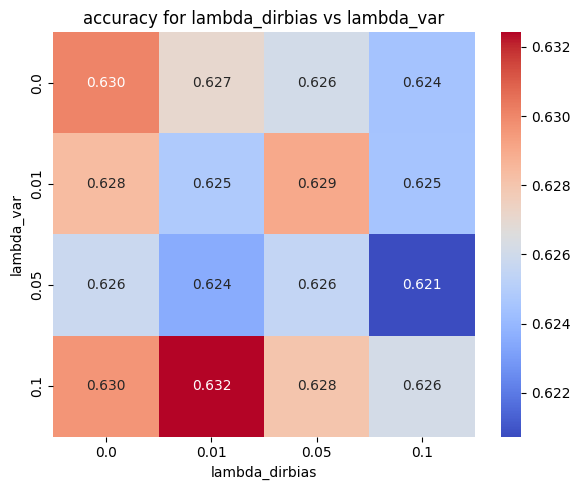

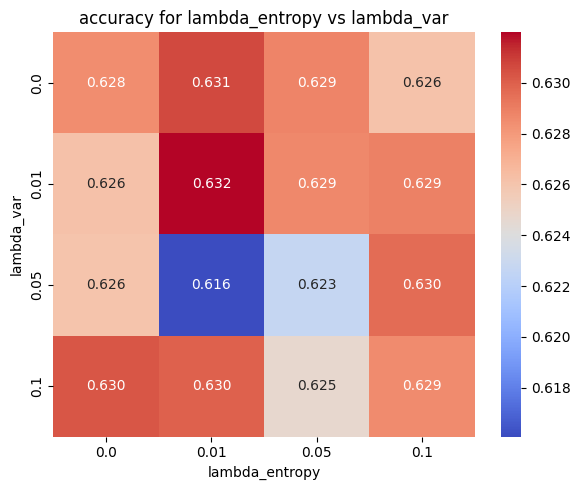

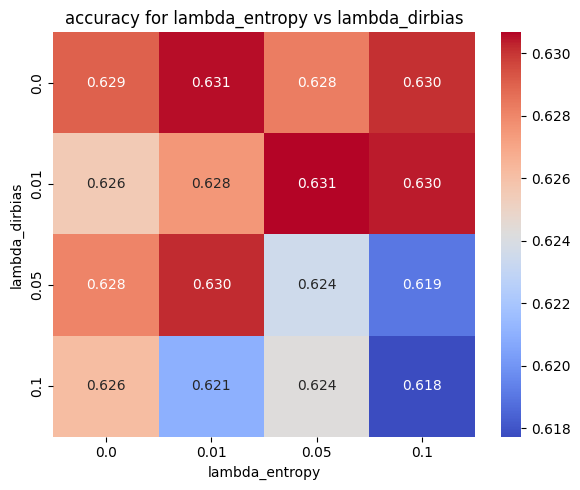


Top configs by accuracy:
     accuracy  test_loss  lambda_dirbias  lambda_entropy  lambda_var  dirbias  \
256  0.660625   2.087144             0.0            0.00        0.00    False   
70   0.657250   2.162857             0.0            0.01        0.00     True   
270  0.655750   2.212075             0.0            0.10        0.05    False   
198  0.654875   2.101092             0.0            0.00        0.00     True   
366  0.653875   2.133877             0.0            0.10        0.00    False   
0    0.653250   2.121372             0.0            0.00        0.00     True   
311  0.651750   2.171291             0.0            0.01        0.10    False   
197  0.651500   2.215993             0.0            0.00        0.00     True   
415  0.650750   2.250115             0.0            0.00        0.10    False   
79   0.650625   2.180280             0.0            0.10        0.00     True   

     entropy    var  
256     True   True  
70      True  False  
270     True   T

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# === Загрузка логов с приведением отключённых lambda к 0.0 ===
def load_log_jsonl(log_path):
    records = []
    with open(log_path, "r") as f:
        for line in f:
            obj = json.loads(line)
            reg = obj["reg_opts"]
            # Приведение к 0.0, если регуляризатор отключен
            reg["lambda_dirbias"] = reg["lambda_dirbias"] if reg.get("dirbias", False) else 0.0
            reg["lambda_entropy"] = reg["lambda_entropy"] if reg.get("entropy", False) else 0.0
            reg["lambda_var"] = reg["lambda_var"] if reg.get("var", False) else 0.0
            record = {
                "accuracy": obj["accuracy"],
                "test_loss": obj["test_loss"],
                "macro_f1": obj.get("macro_f1"),
                "weighted_f1": obj.get("weighted_f1"),
                "runtime_sec": obj["runtime_sec"],
                "uid": obj["uid"],
                "method": obj["method"],
                **reg,
            }
            records.append(record)
    return pd.DataFrame(records)


# === Анализ средней эффективности флагов и λ-параметров ===
def summarize_regularization_effects(df):
    flag_columns = ["dirbias", "entropy", "var"]
    lambda_columns = ["lambda_dirbias", "lambda_entropy", "lambda_var"]

    print("=== Mean Accuracy by Binary Flags ===")
    print(df.groupby(flag_columns)["accuracy"].agg(["mean", "std", "count"]).round(4))

    print("\n=== Mean Accuracy by λ-parameters ===")
    print(df.groupby(lambda_columns)["accuracy"].agg(["mean", "std", "count"]).round(4))


# === Построение тепловых карт влияния параметров ===
def plot_lambda_heatmaps(df, metric="accuracy"):
    pairs = [("lambda_dirbias", "lambda_var"), ("lambda_entropy", "lambda_var"), ("lambda_entropy", "lambda_dirbias")]
    for x, y in pairs:
        pivot = df.pivot_table(index=y, columns=x, values=metric, aggfunc="mean")
        plt.figure(figsize=(6, 5))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="coolwarm")
        plt.title(f"{metric} for {x} vs {y}")
        plt.tight_layout()
        plt.show()


# === Вывод лучших и худших конфигураций ===
def print_extremes(df, metric="accuracy", top_n=10):
    cols = ["accuracy", "test_loss", "lambda_dirbias", "lambda_entropy", "lambda_var", "dirbias", "entropy", "var"]
    print("\nTop configs by accuracy:")
    print(df.sort_values(metric, ascending=False).head(top_n)[cols])
    print("\nWorst configs by accuracy:")
    print(df.sort_values(metric).head(top_n)[cols])


# === Запуск анализа ===
log_path = f"{root_dir}/log_TLP.jsonl"
df = load_log_jsonl(log_path)

summarize_regularization_effects(df)
plot_lambda_heatmaps(df)
print_extremes(df)

# TLP (Learnable Tropical Pooling) комбинирует значения в 2×2 окне с помощью обучаемых смещений к каждому положению. Регуляризации направлены на:

- dirbias — подавление или усиление направленного предпочтения (например, к верхнему левому углу).
- entropy — поощрение равномерности распределения весов (против переобучения на 1–2 направления).
- var — увеличение различий между весами, то есть повышение анизотропии (снятие излишней симметрии, резкое выделение направлений).

# Возможные направления для стабилизации
1. Регуляризация на стабильность веса
Добавить темпоральную регуляризацию веса TLP, которая штрафует резкие колебания весов между эпохами:

python
Копировать
Редактировать
reg_stability = torch.mean((tlp_weights_current - tlp_weights_prev) ** 2)
2. Пульсирующий запуск TLP
Вариант: TLP не активен на каждой эпохе, а только с вероятностью p, увеличивающейся к концу обучения. Это может помочь ядрам стабилизироваться, а TLP «подстроиться» уже в зрелой фазе.

3. Пространственная маска признака
Можно пытаться стабилизировать реакцию TLP через маску важности на выходах conv2:

Научить модель замедлять TLP там, где признаки стабильны во времени или пространстве.

Или наоборот, активировать TLP, где feature map содержит границы.

4. Инициализация ядра по MaxPooling
Если первые веса TLP близки к MaxPooling, возможно стоит инициализировать веса как [0, 0, 0, 0] и обучать их на небольшом lr, чтобы модель отклонялась от MaxPooling только там, где это выгодно.

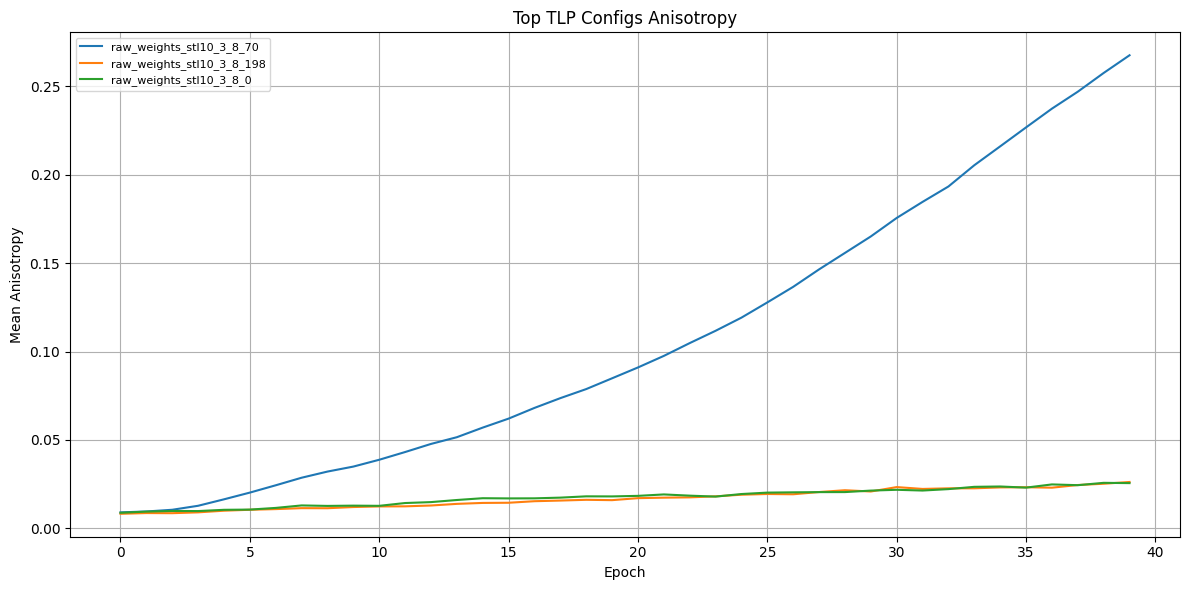

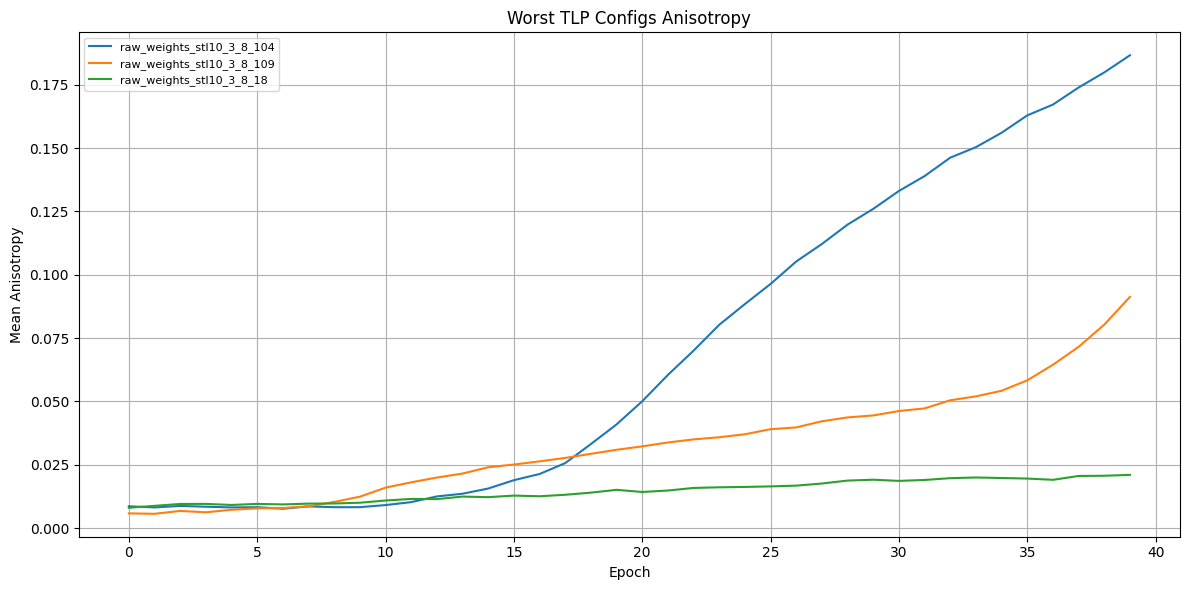

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import os
import pickle
import numpy as np


def load_all_tlp_trajectories(base_dir, layer="pool2"):
    """
    Загружает траектории TLP-весов из всех подкаталогов.

    Args:
        base_dir (str): Базовая папка, содержащая подпапки экспериментов.
        layer (str): Название слоя (например, 'pool2').

    Returns:
        dict: {путь_к_подпапке: np.ndarray [epochs, channels, 4]}
    """
    experiments = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and d.startswith("raw_weights_stl10")]

    all_trajectories = {}

    for exp_path in experiments:
        files = sorted([f for f in os.listdir(exp_path) if f.endswith(".pkl")], key=lambda f: int(f.split("_")[1].split(".")[0]))  # предполагается формат 'epoch_XX.pkl'

        exp_weights = []
        for fname in files:
            file_path = os.path.join(exp_path, fname)
            with open(file_path, "rb") as f:
                data = pickle.load(f)
                key = f"{layer}_weights"
                if key not in data:
                    raise KeyError(f"'{key}' не найден в {fname}")
                weights = data[key]  # (channels, 4)
                exp_weights.append(weights)

        all_trajectories[exp_path] = np.stack(exp_weights)

    return all_trajectories


def compute_anisotropy(weights):
    """
    Вычисляет анизотропию весов TLP: стандартное отклонение от среднего по 4 весам.
    Args:
        weights: np.array [epochs, channels, 4]
    Returns:
        mean_anisotropy_per_epoch: список средних значений по эпохам
    """
    anisotropy_epochs = []
    for epoch_weights in weights:  # [channels, 4]
        diffs = epoch_weights - epoch_weights.mean(axis=1, keepdims=True)
        anisotropy = np.sqrt((diffs**2).mean(axis=1))  # [channels]
        anisotropy_epochs.append(anisotropy.mean())  # среднее по каналам
    return anisotropy_epochs


def plot_anisotropy_trajectories(trajectories, selected_experiments=None, title="TLP Anisotropy Evolution"):
    """
    Строит графики эволюции анизотропии для выбранных экспериментов.

    Args:
        trajectories: dict {path: weights}
        selected_experiments: список ключей (путей) для отображения, если None — все
        title: заголовок графика
    """
    plt.figure(figsize=(12, 6))

    if selected_experiments is None:
        selected_experiments = list(trajectories.keys())

    for exp_path in selected_experiments:
        anisotropy = compute_anisotropy(trajectories[exp_path])
        plt.plot(anisotropy, label=os.path.basename(exp_path))

    plt.xlabel("Epoch")
    plt.ylabel("Mean Anisotropy")
    plt.title(title)
    plt.grid(True)
    plt.legend(fontsize=8, loc="best")
    plt.tight_layout()
    plt.show()


# Загрузили все траектории
trajectories = load_all_tlp_trajectories(base_dir="./TLP")

# Например, отберем лучшие и худшие эксперименты по заранее известному списку:
top_experiments = ["./TLP\\raw_weights_stl10_3_8_70", "./TLP\\raw_weights_stl10_3_8_198", "./TLP\\raw_weights_stl10_3_8_0"]

worst_experiments = ["./TLP\\raw_weights_stl10_3_8_104", "./TLP\\raw_weights_stl10_3_8_109", "./TLP\\raw_weights_stl10_3_8_18"]

# Построим лучшие
plot_anisotropy_trajectories(trajectories, selected_experiments=top_experiments, title="Top TLP Configs Anisotropy")

# Построим худшие
plot_anisotropy_trajectories(trajectories, selected_experiments=worst_experiments, title="Worst TLP Configs Anisotropy")

In [9]:
def print_extremes(df, metric="accuracy", top_n=10):
    cols = ["accuracy", "test_loss", "runtime_sec", "lambda_dirbias", "lambda_entropy", "lambda_var", "dirbias", "entropy", "var"]
    print("\n=== Top configs by accuracy ===")
    print(df.sort_values(metric, ascending=False)[cols].head(top_n).to_string(index=False))

    print("\n=== Worst configs by accuracy ===")
    print(df.sort_values(metric, ascending=True)[cols].head(top_n).to_string(index=False))


print_extremes(df)


=== Top configs by accuracy ===
 accuracy  test_loss  runtime_sec  lambda_dirbias  lambda_entropy  lambda_var  dirbias  entropy   var
 0.660625   2.087144      1423.39             0.0            0.00        0.00    False     True  True
 0.657250   2.162857      1365.40             0.0            0.01        0.00     True     True False
 0.655750   2.212075      1422.64             0.0            0.10        0.05    False     True  True
 0.654875   2.101092      1396.47             0.0            0.00        0.00     True    False False
 0.653875   2.133877      1483.99             0.0            0.10        0.00    False     True False
 0.653250   2.121372      1610.44             0.0            0.00        0.00     True     True  True
 0.651750   2.171291      1456.68             0.0            0.01        0.10    False     True  True
 0.651500   2.215993      1398.39             0.0            0.00        0.00     True    False False
 0.650750   2.250115      1419.33             0.0

In [10]:
import os
import pickle
import numpy as np
import plotly.graph_objs as go
import plotly.express as px


def load_all_tlp_trajectories(base_dir, selected_dirs=None):
    """
    Загружает анизотропию для всех экспериментов
    :param base_dir: путь к папке с папками вида raw_weights_stl10_3_8_0, raw_weights_stl10_3_8_1 и т.д.
    :param selected_dirs: список папок для загрузки (если None — все)
    :return: словарь {название папки: массив анизотропии (epochs, channels)}
    """
    trajectories = {}
    all_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("raw_weights_stl10_3_8")])

    if selected_dirs is not None:
        all_dirs = [d for d in all_dirs if d in selected_dirs]

    for d in all_dirs:
        path = os.path.join(base_dir, d)
        weight_files = sorted([f for f in os.listdir(path) if f.endswith(".pkl")], key=lambda x: int(x.split("_")[1].split(".")[0]))
        channelwise_anisotropy = []

        for file in weight_files:
            with open(os.path.join(path, file), "rb") as f:
                data = pickle.load(f)
                weights = data["pool2_weights"]  # (C, 4)
                diffs = weights - weights.mean(axis=1, keepdims=True)
                anisotropy_per_channel = np.sqrt((diffs**2).mean(axis=1))  # (C,)
                channelwise_anisotropy.append(anisotropy_per_channel)

        trajectories[d] = np.stack(channelwise_anisotropy, axis=0)  # (epochs, channels)

    return trajectories


import json
import pandas as pd


def select_top_experiments(log_path, top_n=3):
    """
    Загружает лог-файл и возвращает имена лучших экспериментов по accuracy.
    """
    records = []
    with open(log_path, "r") as f:
        for line in f:
            record = json.loads(line)
            records.append(record)

    df = pd.DataFrame(records)
    df["experiment_name"] = df["save_dir"].apply(lambda x: os.path.basename(x))  # например raw_weights_stl10_3_8_70

    top_df = df.sort_values("accuracy", ascending=False).head(top_n)
    return top_df["experiment_name"].tolist()


def plot_channelwise_anisotropy_plotly(trajectories, selected_experiments, title="TLP Channelwise Anisotropy"):
    fig = go.Figure()
    color_map = px.colors.qualitative.Set1

    for idx, exp_name in enumerate(selected_experiments):
        channelwise = trajectories[exp_name]  # shape: (epochs, channels)

        # Проверка формы
        if len(channelwise.shape) == 1:
            channelwise = channelwise[:, np.newaxis]

        n_epochs, n_channels = channelwise.shape

        for ch in range(n_channels):
            fig.add_trace(
                go.Scatter(
                    y=channelwise[:, ch],
                    x=list(range(n_epochs)),
                    mode="lines",
                    line=dict(color=color_map[idx % len(color_map)], width=1),
                    name=f"{exp_name} - ch{ch}",
                    legendgroup=exp_name,
                    showlegend=(ch == 0),  # подпись только один раз для каждого эксперимента
                )
            )

    fig.update_layout(title=title, xaxis_title="Epoch", yaxis_title="Channelwise Anisotropy", hovermode="closest", width=1000, height=600)
    fig.show()


# Параметры
log_path = f"{base_dir}/log_TLP.jsonl"

# Загрузка
top_experiments = select_top_experiments(log_path, top_n=3)
trajectories = load_all_tlp_trajectories(base_dir, selected_dirs=top_experiments)

# Построение
plot_channelwise_anisotropy_plotly(trajectories, top_experiments, title="Top TLP Configs Anisotropy (Channelwise)")

NameError: name 'base_dir' is not defined

In [ ]:
groups.keys()

dict_keys(['flat', 'slow', 'explosive'])

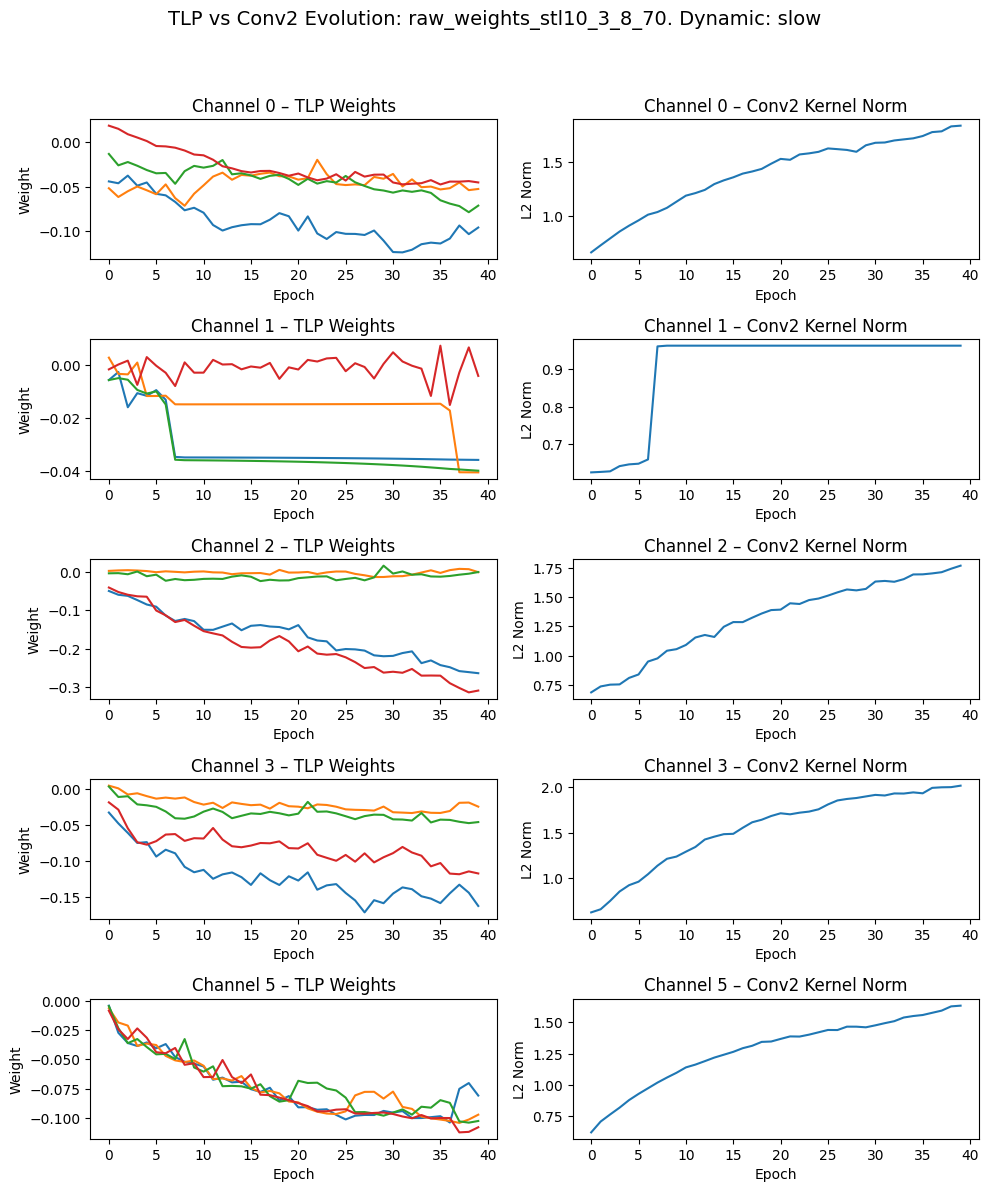

In [ ]:
import numpy as np


def classify_tlp_channels_by_growth(channelwise_trajectory, flat_thresh=0.01, slope_thresh=0.005, explosive_thresh=0.03):
    """
    Классифицирует признаки по траекториям анизотропии TLP.

    Параметры:
    - channelwise_trajectory: np.ndarray формы [epochs, channels]
    - flat_thresh: макс. диапазон изменения для Flat
    - slope_thresh: градиент для Slow rise
    - explosive_thresh: градиент для Explosive

    Возвращает:
    - dict с ключами: 'flat', 'slow', 'explosive', содержащими индексы каналов
    """
    n_epochs, n_channels = channelwise_trajectory.shape
    result = {"flat": [], "slow": [], "explosive": []}

    for ch in range(n_channels):
        y = channelwise_trajectory[:, ch]
        delta = y[-1] - y[0]
        range_ = y.max() - y.min()
        slope = delta / n_epochs

        if range_ < flat_thresh:
            result["flat"].append(ch)
        elif slope > explosive_thresh:
            result["explosive"].append(ch)
        else:
            result["slow"].append(ch)

    return result


# Пример: trajectories["raw_weights_stl10_3_8_70"] — массив [epochs, channels]
groups = classify_tlp_channels_by_growth(trajectories["raw_weights_stl10_3_8_70"])

# Получить каналы из группы Explosive
dynamic_type = "slow"
explosive_channels = groups[dynamic_type]

# Передать их в функцию визуализации:
plot_tlp_vs_kernel_evolution("./TLP/raw_weights_stl10_3_8_70", selected_channels=explosive_channels[:5], dynamic_type=dynamic_type)

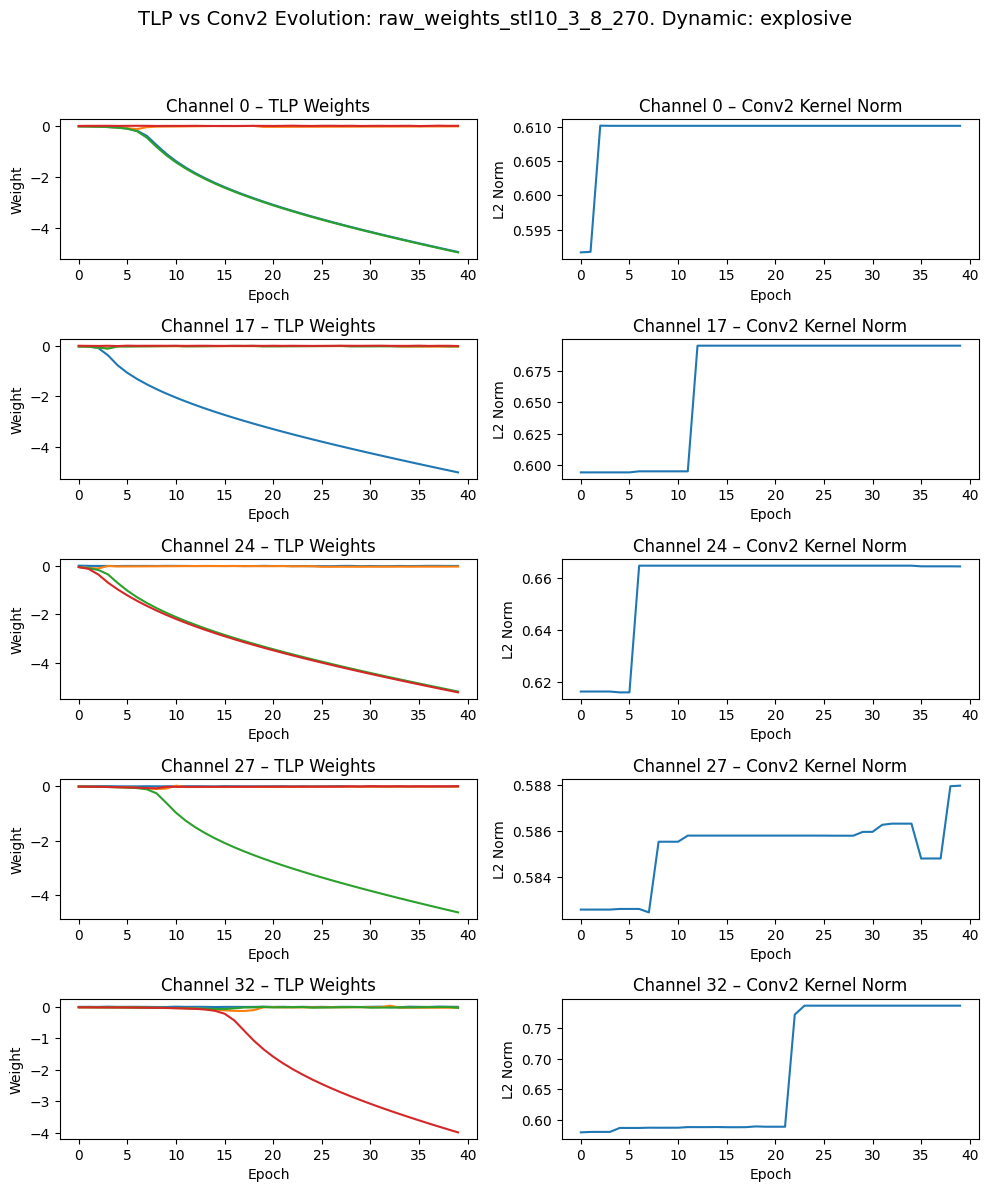

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


def plot_tlp_vs_kernel_evolution(exp_dir, selected_channels=None, layer="pool2", dynamic_type="any"):
    """
    Визуализирует эволюцию TLP весов и conv2 ядер по каналам.
    """
    weight_files = sorted([f for f in os.listdir(exp_dir) if f.endswith(".pkl")], key=lambda x: int(x.split("_")[1].split(".")[0]))

    # Выбор каналов по последнему файлу
    with open(os.path.join(exp_dir, weight_files[-1]), "rb") as f:
        data = pickle.load(f)
    n_channels = data[f"{layer}_weights"].shape[0]
    if selected_channels is None:
        selected_channels = list(range(min(5, n_channels)))

    fig, axes = plt.subplots(len(selected_channels), 2, figsize=(10, 2.5 * len(selected_channels)))
    fig.suptitle(f"TLP vs Conv2 Evolution: {os.path.basename(exp_dir)}. Dynamic: {dynamic_type}", fontsize=14)

    for i, ch in enumerate(selected_channels):
        tlp_evolution = []
        kernel_norms = []

        for fname in weight_files:
            with open(os.path.join(exp_dir, fname), "rb") as f:
                weights = pickle.load(f)

                tlp = weights[f"{layer}_weights"][ch]
                kernel = weights["conv2_kernels"][ch]

                # Убедимся, что всё в numpy
                if hasattr(tlp, "detach"):
                    tlp = tlp.detach().cpu().numpy()
                if hasattr(kernel, "detach"):
                    kernel = kernel.detach().cpu().numpy()

                tlp_evolution.append(tlp)
                kernel_norms.append(np.linalg.norm(kernel))

        # Plot TLP vector evolution (4 dim)
        axes[i, 0].plot(tlp_evolution)
        axes[i, 0].set_title(f"Channel {ch} – TLP Weights")
        axes[i, 0].set_ylabel("Weight")
        axes[i, 0].set_xlabel("Epoch")

        # Plot kernel norm
        axes[i, 1].plot(kernel_norms)
        axes[i, 1].set_title(f"Channel {ch} – Conv2 Kernel Norm")
        axes[i, 1].set_ylabel("L2 Norm")
        axes[i, 1].set_xlabel("Epoch")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Укажи папки с весами топ-экспериментов
top_dirs = ["./TLP/raw_weights_stl10_3_8_70", "./TLP/raw_weights_stl10_3_8_256", "./TLP/raw_weights_stl10_3_8_270"]

""" # Запуск по каждому эксперименту
for d in top_dirs:
    plot_tlp_vs_kernel_evolution(d, selected_channels=[0, 4, 15, 33, 48]) """


def classify_tlp_channels_by_growth(channelwise_trajectory, flat_thresh=0.01, slope_thresh=0.005, explosive_thresh=0.03):
    """
    Классифицирует признаки по траекториям анизотропии TLP.

    Параметры:
    - channelwise_trajectory: np.ndarray формы [epochs, channels]
    - flat_thresh: макс. диапазон изменения для Flat
    - slope_thresh: градиент для Slow rise
    - explosive_thresh: градиент для Explosive

    Возвращает:
    - dict с ключами: 'flat', 'slow', 'explosive', содержащими индексы каналов
    """
    n_epochs, n_channels = channelwise_trajectory.shape
    result = {"flat": [], "slow": [], "explosive": []}

    for ch in range(n_channels):
        y = channelwise_trajectory[:, ch]
        delta = y[-1] - y[0]
        range_ = y.max() - y.min()
        slope = delta / n_epochs

        if range_ < flat_thresh:
            result["flat"].append(ch)
        elif slope > explosive_thresh:
            result["explosive"].append(ch)
        else:
            result["slow"].append(ch)

    return result


# Пример: trajectories["raw_weights_stl10_3_8_70"] — массив [epochs, channels]
groups = classify_tlp_channels_by_growth(trajectories["raw_weights_stl10_3_8_270"])

# Получить каналы из группы Explosive
dynamic_type = "explosive"
explosive_channels = groups[dynamic_type]

# Передать их в функцию визуализации:
plot_tlp_vs_kernel_evolution(top_dirs[2], selected_channels=explosive_channels[:5], dynamic_type=dynamic_type)